************************************************************************************************************
* 题目：巴拉巴西-阿尔伯特网络 BA网络
* 制作者:版权所有,柳承睿、蒲鹏 Email:ppu@cc.ecnu.edu.cn；
* 最后更新日期：2022-6-1
* 补充掌握内容：https://blog.csdn.net/weixin_43957565/article/details/121200564
html  官方示例和JPT代码
* 声明：在转发并拷贝的过程中，请保留版权信息
************************************************************************************************************

该文件主要对数据进行处理

In [28]:
# %load "mylib\mymath.py"

In [1]:
import random
import time
import numpy as np
import pandas as pd
import scipy
#加载依赖库
import networkx as nx
from matplotlib import pyplot as plt
#自定义函数
from mylib.mymath import random_unit
from mylib.mymath import log_binning  #对数分箱
from mylib.mymath import number_of_certain_prob  #根据概率分布，输出结果
import warnings
warnings.filterwarnings("ignore")
m=2 #每个节点带来两条边
totalT=10000 #实验观察 500个时间步
print(scipy.__version__)

1.8.0


In [30]:
np.seterr(divide='ignore',invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

## 实验1 开发生长型BA模拟器

### 步骤1 按照BA定义创建BA网络

t0时刻，初始化两个点，作为BA网络开始

In [31]:
G_BA = nx.Graph()
nodes=pd.DataFrame()
edges=pd.DataFrame()
#生长参数 m=2 t=500
m=2 #每个节点带来两条边
totalT=10000 #实验观察 500个时间步

In [32]:
def draw_network_basic(G):
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    dmax = max(degree_sequence)
    fig = plt.figure("Degree of a random graph", figsize=(8, 8))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(5, 4)
    ax0 = fig.add_subplot(axgrid[0:3, :])
    Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
    pos = nx.spring_layout(Gcc, seed=10396953)
    nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
    nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
    ax0.set_title("Connected components of G")
    ax0.set_axis_off()
    ax1 = fig.add_subplot(axgrid[3:, :2])
    ax1.plot(degree_sequence, "b-", marker="o")
    ax1.set_title("Degree Rank Plot")
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("Rank")
    ax2 = fig.add_subplot(axgrid[3:, 2:])
    ax2.bar(*np.unique(degree_sequence, return_counts=True))
    ax2.set_title("Degree histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("# of Nodes")
    fig.tight_layout()

In [33]:
#  根据边的变化情况，更新网络
def update_network(showcontent=True):
        global G_BA 
        global edges
        # 生成新的图
        edges_not_active=edges[edges.active==0]
        #为了提升效率，只针对未被激活的边，进行添加。如果该边被添加过了，那么active设置为1
        for i,row in edges_not_active.iterrows():
                G_BA.add_edges_from([(row.n_start, row.n_end, {"weight":row.weight})])
                row.active=1
                edges.iloc[i] = row
        if(showcontent):
                draw_network_basic(G_BA)

In [34]:
#返回节点列表中所有节点的度/度综合（概率分布）
def getNodesP(temp_nodes):
    p_nodes=[]
    denominator = 0
    for index,raw in temp_nodes.iterrows():
        denominator += raw.d
    for index,raw in temp_nodes.iterrows():
        # start----BA的定义，核心逻辑
        p=raw.d/denominator  #某个节点的概率
        p_nodes.append(p)
    return p_nodes  #返回所有节点的度/度综合（概率）

In [35]:
#网络初始化函数
def __init__(show_content=True):
    global G_BA 
    global edges
    global nodes
    G_BA = nx.Graph()
    #为了方便计算采用了dataframe数据结构存储节点
    nodes=pd.DataFrame( [{"t":"t0","label":"n0","d":1},{"t":"t0","label":"n1","d":1}])
    print("---"*10)
    #假设是无权无向网络
    #t0时刻，初始化一条边，作为BA网络开始
    temp_list=[("t0",nodes.iloc[0,1],nodes.iloc[1,1],0,0)]
    edges=pd.DataFrame(temp_list,columns=['t','n_start','n_end','weight','active'])
    if(show_content):
        print("t0时间步点的集合：\n",nodes)
        print("t0时刻边的集合：\n",edges)
        print("开始初始化网络.......")
    update_network(show_content)

------------------------------
t0时间步点的集合：
     t label  d
0  t0    n0  1
1  t0    n1  1
t0时刻边的集合：
     t n_start n_end  weight  active
0  t0      n0    n1       0       0
开始初始化网络.......


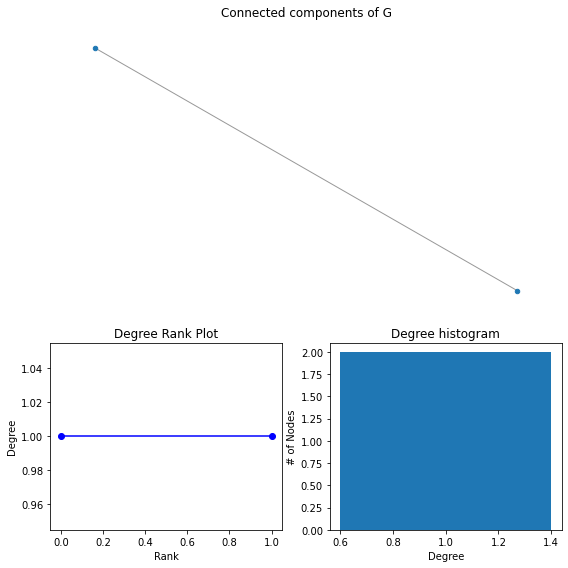

In [36]:
__init__()

### 步骤2 生长函数 （本实验最重要的函数，BA的原理全都在这个函数里）

In [37]:
# t---某个时刻  nums ----该时刻添加的节点的数量  
# edges_num--- 每个节点带来的边的数量  showcontent要不要显示图，单次生长可以观察图，多次生长看最后总图即可
def grows(t="t1",nodes_num=0,edges_num=0,showcontent=True):
    print(f"第{t}时刻正在生长.....,会生长{nodes_num}个节点，{edges_num}条边")
    global edges
    global nodes
    #前一个时刻的nodes长度
    ln=len(nodes)
    #组网前，对节点深拷贝做个备份，因为对同一个节点，每找到一个新边，旧的节点就得去掉，
    # 否则，容易两个边连接到同一个节点。
    temp_nodes=nodes.copy() 
    for k in range(0,nodes_num):#生成nodes_num个节点
        #每一个新来的节点
        if(edges_num==0):
            edges_num=np.random.randint(ln)  # 假设新节点带来的边数也是随机的，这个随机值必须小于节点数
        newnode_label="n"+str(k+ln)
        newnode={"t":t,"label":newnode_label,"d":edges_num} #新节点的度肯定是，它带来的边的数量
        print(f"第{t}时刻{k+1}个新的节点{newnode_label}带来了{edges_num}条边")
        # 对一个新节点，要处理它的每一条新增的边，都要按照概率从原有的节点中，找到一个去组成边
        for m0 in range(0,edges_num): 
            #按照概率找出合适的节点findnodeByP
            findnodeByP = number_of_certain_prob(list(temp_nodes.label), getNodesP(temp_nodes))  
            print(f"第{m0+1}条边，链接到节点{findnodeByP}----->{newnode_label}")
            #组建新边
            new_edge={'t': t,"n_start":findnodeByP,"n_end":newnode["label"],"weight":0,"active":0}
            edges=edges.append(new_edge, ignore_index=True)
            #更新 findnodeByP 的度
            nodes.loc[nodes.label==findnodeByP,'d']+=1
            #组建好边的节点，删除之，下次组边就不会选择这个节点
            temp_nodes=temp_nodes.drop(temp_nodes.index[temp_nodes.label==findnodeByP])
        #新节点的所有边，都插入到网络中，新节点插到节点表中
        nodes=nodes.append(newnode, ignore_index=True)
    #更新网络
    update_network(showcontent)

### 步骤3 模拟生长 (本实验最重要的步骤)

In [38]:
__init__(show_content=False) #初始化

------------------------------


下面这个生长非常耗时间，承睿可以优化下，但这个生长获取的数据，非常重要。我只模拟了500个T，越多越好。

In [39]:
#生长参数 每个时间步，增加m=2条边，1个节点，总共模拟 totalT=500
for i in range(1,totalT):
    grows("t"+str(i),1,m,False)
    #time.sleep(1)  #不加等待貌似会报错，承睿也可以优化
    # 我这里不会报错？

第t1时刻正在生长.....,会生长1个节点，2条边
第t1时刻1个新的节点n2带来了2条边
第1条边，链接到节点n0----->n2
第2条边，链接到节点n1----->n2
第t2时刻正在生长.....,会生长1个节点，2条边
第t2时刻1个新的节点n3带来了2条边
第1条边，链接到节点n1----->n3
第2条边，链接到节点n0----->n3
第t3时刻正在生长.....,会生长1个节点，2条边
第t3时刻1个新的节点n4带来了2条边
第1条边，链接到节点n2----->n4
第2条边，链接到节点n3----->n4
第t4时刻正在生长.....,会生长1个节点，2条边
第t4时刻1个新的节点n5带来了2条边
第1条边，链接到节点n2----->n5
第2条边，链接到节点n0----->n5
第t5时刻正在生长.....,会生长1个节点，2条边
第t5时刻1个新的节点n6带来了2条边
第1条边，链接到节点n3----->n6
第2条边，链接到节点n1----->n6
第t6时刻正在生长.....,会生长1个节点，2条边
第t6时刻1个新的节点n7带来了2条边
第1条边，链接到节点n2----->n7
第2条边，链接到节点n3----->n7
第t7时刻正在生长.....,会生长1个节点，2条边
第t7时刻1个新的节点n8带来了2条边
第1条边，链接到节点n0----->n8
第2条边，链接到节点n5----->n8
第t8时刻正在生长.....,会生长1个节点，2条边
第t8时刻1个新的节点n9带来了2条边
第1条边，链接到节点n3----->n9
第2条边，链接到节点n4----->n9
第t9时刻正在生长.....,会生长1个节点，2条边
第t9时刻1个新的节点n10带来了2条边
第1条边，链接到节点n4----->n10
第2条边，链接到节点n0----->n10
第t10时刻正在生长.....,会生长1个节点，2条边
第t10时刻1个新的节点n11带来了2条边
第1条边，链接到节点n2----->n11
第2条边，链接到节点n9----->n11
第t11时刻正在生长.....,会生长1个节点，2条边
第t11时刻1个新的节点n12带来了2条边
第1条边，链接到节点n4----->n12
第2条边，链接到节点n2----->n12
第t12时刻正在

将生成的结果保存下

In [45]:
nodes.to_csv(f"{totalT}nodesBAnodes.csv")
edges.to_csv(f"{totalT}nodesBAedges.csv")

In [5]:
nodes = pd.DataFrame(pd.read_csv("10000nodesBAnodes.csv"))
edges = pd.DataFrame(pd.read_csv("10000nodesBAedges.csv"))

观察图

In [ ]:
draw_network_basic(G_BA)

: 

: 

### 步骤4 线性分箱、对数分箱下的度分布

p(k)=度为K的节点数量/总的节点的数量。
这个链接做的图，是非常不错的。https://view.inews.qq.com/a/20220427A040YC00

TypeError: float() argument must be a string or a number, not 'pandas._libs.interval.Interval'

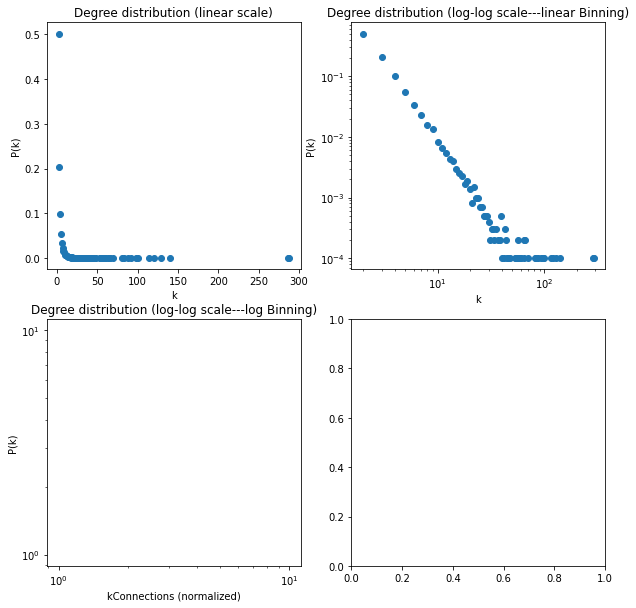

In [6]:
from collections import Counter
from sklearn import linear_model
fig2v2New=plt.figure(figsize=(10 ,10))
ax4_1=fig2v2New.add_subplot(2,2,1)
ax4_2=plt.subplot(2,2,2)  #等效于ax4_2=fig2v2New.add_subplot(2,2,2)
ax4_3=fig2v2New.add_subplot(2,2,3)
ax4_4=fig2v2New.add_subplot(2,2,4)
k_list=[]
pk_list=[]
c=Counter(nodes.d)
#按照值从小到大排序
cc=sorted(c.items(),key=lambda x:x[0]) 
#print(cc)
#线性标度图
for tmpk_nums in cc:
    k_list.append(tmpk_nums[0])
    pk_list.append(tmpk_nums[1]/len(nodes))

ax4_1.set_title('Degree distribution (linear scale)')
ax4_1.set_ylabel('P(k)')
ax4_1.set_xlabel('k')
ax4_1.scatter(k_list,pk_list)
#双对数坐标-----线性分箱
# pk_list=np.log10(np.array(pk_list))
# k_list=np.log10(np.array(k_list))
ax4_2.set_title('Degree distribution (log-log scale---linear Binning)')
ax4_2.set_ylabel('P(k)')
ax4_2.set_xlabel('k')
ax4_2.set_xscale('log')
ax4_2.set_yscale('log')
# regr = linear_model.LinearRegression()
# regr.fit(np.array(k_list).reshape(-1, 1), np.array(pk_list).reshape(-1, 1),)
# ax4_2.plot(k_list, regr.predict(np.array(k_list).reshape(-1, 1)), color='red', linewidth=1)
ax4_2.scatter(k_list,pk_list)
#双对数坐标-----对数分箱
# 这里写错了，怎么会是度中心性？跟着没关系把？但是不知道怎么改
# To convert normalized degrees to raw degrees
ba_c2 = dict(zip(k_list, pk_list))
# 这个函数我不知道是不是写错了，书上的log binning图非常好看，我这个感觉和线性binning没区别
# 书上page176
ba_x,ba_y = log_binning(ba_c2,50)
ax4_3.set_xscale("log")
ax4_3.set_yscale("log")
ax4_3.set_title('Degree distribution (log-log scale---log Binning)')
ax4_3.set_ylabel('P(k)')
ax4_3.set_xlabel('kConnections (normalized)')
# ax4_3.set_xlim((1e-4,1e-1))
# ax4_3.set_ylim((.9,1e4))
ax4_3.scatter(ba_x,ba_y,c='b',marker='x')

（a）线性坐标，线性分箱：在线性坐标下，幂律分布很难看清。因此，我们通常会使用双对数坐标来绘制无标度网络的度分布。
（b）双对数坐标，线性分箱：此时，分布的尾部清晰可见，但在k较大的区域有一个平缓区，这是线性分箱的结果。
（c）双对数坐标，对数分箱：对数分箱使得平缓区消失了，标度扩展到了k较大的区域。为便于对照，我们用浅灰色给出了（b）中线性分箱的结果。
（d）双对数坐标，累积分布：双对数坐标下的累积度分布。

In [ ]:
print ("所有节点的度",G_BA.degree() )                                    #返回所有节点的度
print ("所有节点的度分布序列:",nx.degree_histogram(G_BA))    #返回图中所有节点的度分布序列（从1至最大度的出现频次）

所有节点的度 [('n0', 49), ('n1', 65), ('n2', 75), ('n3', 12), ('n4', 25), ('n5', 20), ('n6', 16), ('n7', 6), ('n8', 33), ('n9', 4), ('n10', 32), ('n11', 31), ('n12', 31), ('n13', 14), ('n14', 20), ('n15', 15), ('n16', 27), ('n17', 5), ('n18', 25), ('n19', 13), ('n20', 15), ('n21', 20), ('n22', 27), ('n23', 22), ('n24', 7), ('n25', 5), ('n26', 5), ('n27', 10), ('n28', 7), ('n29', 22), ('n30', 15), ('n31', 13), ('n32', 16), ('n33', 22), ('n34', 3), ('n35', 10), ('n36', 9), ('n37', 4), ('n38', 3), ('n39', 23), ('n40', 9), ('n41', 3), ('n42', 19), ('n43', 6), ('n44', 4), ('n45', 15), ('n46', 6), ('n47', 7), ('n48', 8), ('n49', 5), ('n50', 4), ('n51', 2), ('n52', 7), ('n53', 5), ('n54', 15), ('n55', 11), ('n56', 17), ('n57', 3), ('n58', 4), ('n59', 13), ('n60', 12), ('n61', 2), ('n62', 2), ('n63', 9), ('n64', 8), ('n65', 4), ('n66', 5), ('n67', 7), ('n68', 3), ('n69', 11), ('n70', 7), ('n71', 8), ('n72', 10), ('n73', 5), ('n74', 15), ('n75', 10), ('n76', 7), ('n77', 18), ('n78', 8), ('n79', 12), 

## 实验2 网络动力学

### 步骤1 网络中度的变化和生长时刻的幂指数关系beita=0.5的验证

动态指数beita的观察，按照PAGE203  ,经过简单推导得出beita=0.5，即度的增长依照幂律随时间增长。下面随便观察几个节点,验证PAGE203,公式4.7

In [10]:
#观察某个时刻开始，到最终时刻，该时刻新增节点的度的变化
def degree_increase(t=0):
    global totalT
    x_list=[]
    k_list=[]
    n_lable="n"+str(t+1)
    for ti in range(t,totalT):
        
        x_list.append(ti)
        if ti==0: #此时只考虑两个节点n0和n1
            k_list.append(2)
            continue
        tlabel="t"+str(ti) #时刻的标签
        if t==0: #这个时刻点就是为了观察n0和n1
            l1=len(edges[(edges.t==tlabel)&(edges.n_start=='n0')])
            l2=len(edges[(edges.t==tlabel)&(edges.n_start=='n1')])
            k_list.append(k_list[ti-1]+l1+l2)
        else:
            #根据边的数量计算度
            l1=len(edges[(edges.t==tlabel)&(edges.n_start==n_lable)])
            l2=len(edges[(edges.t==tlabel)&(edges.n_end==n_lable)])
            if(k_list==[]):
                k_list.append(l1+l2)
            else:
                k_list.append(k_list[ti-t-1]+l1+l2)
    return x_list,k_list

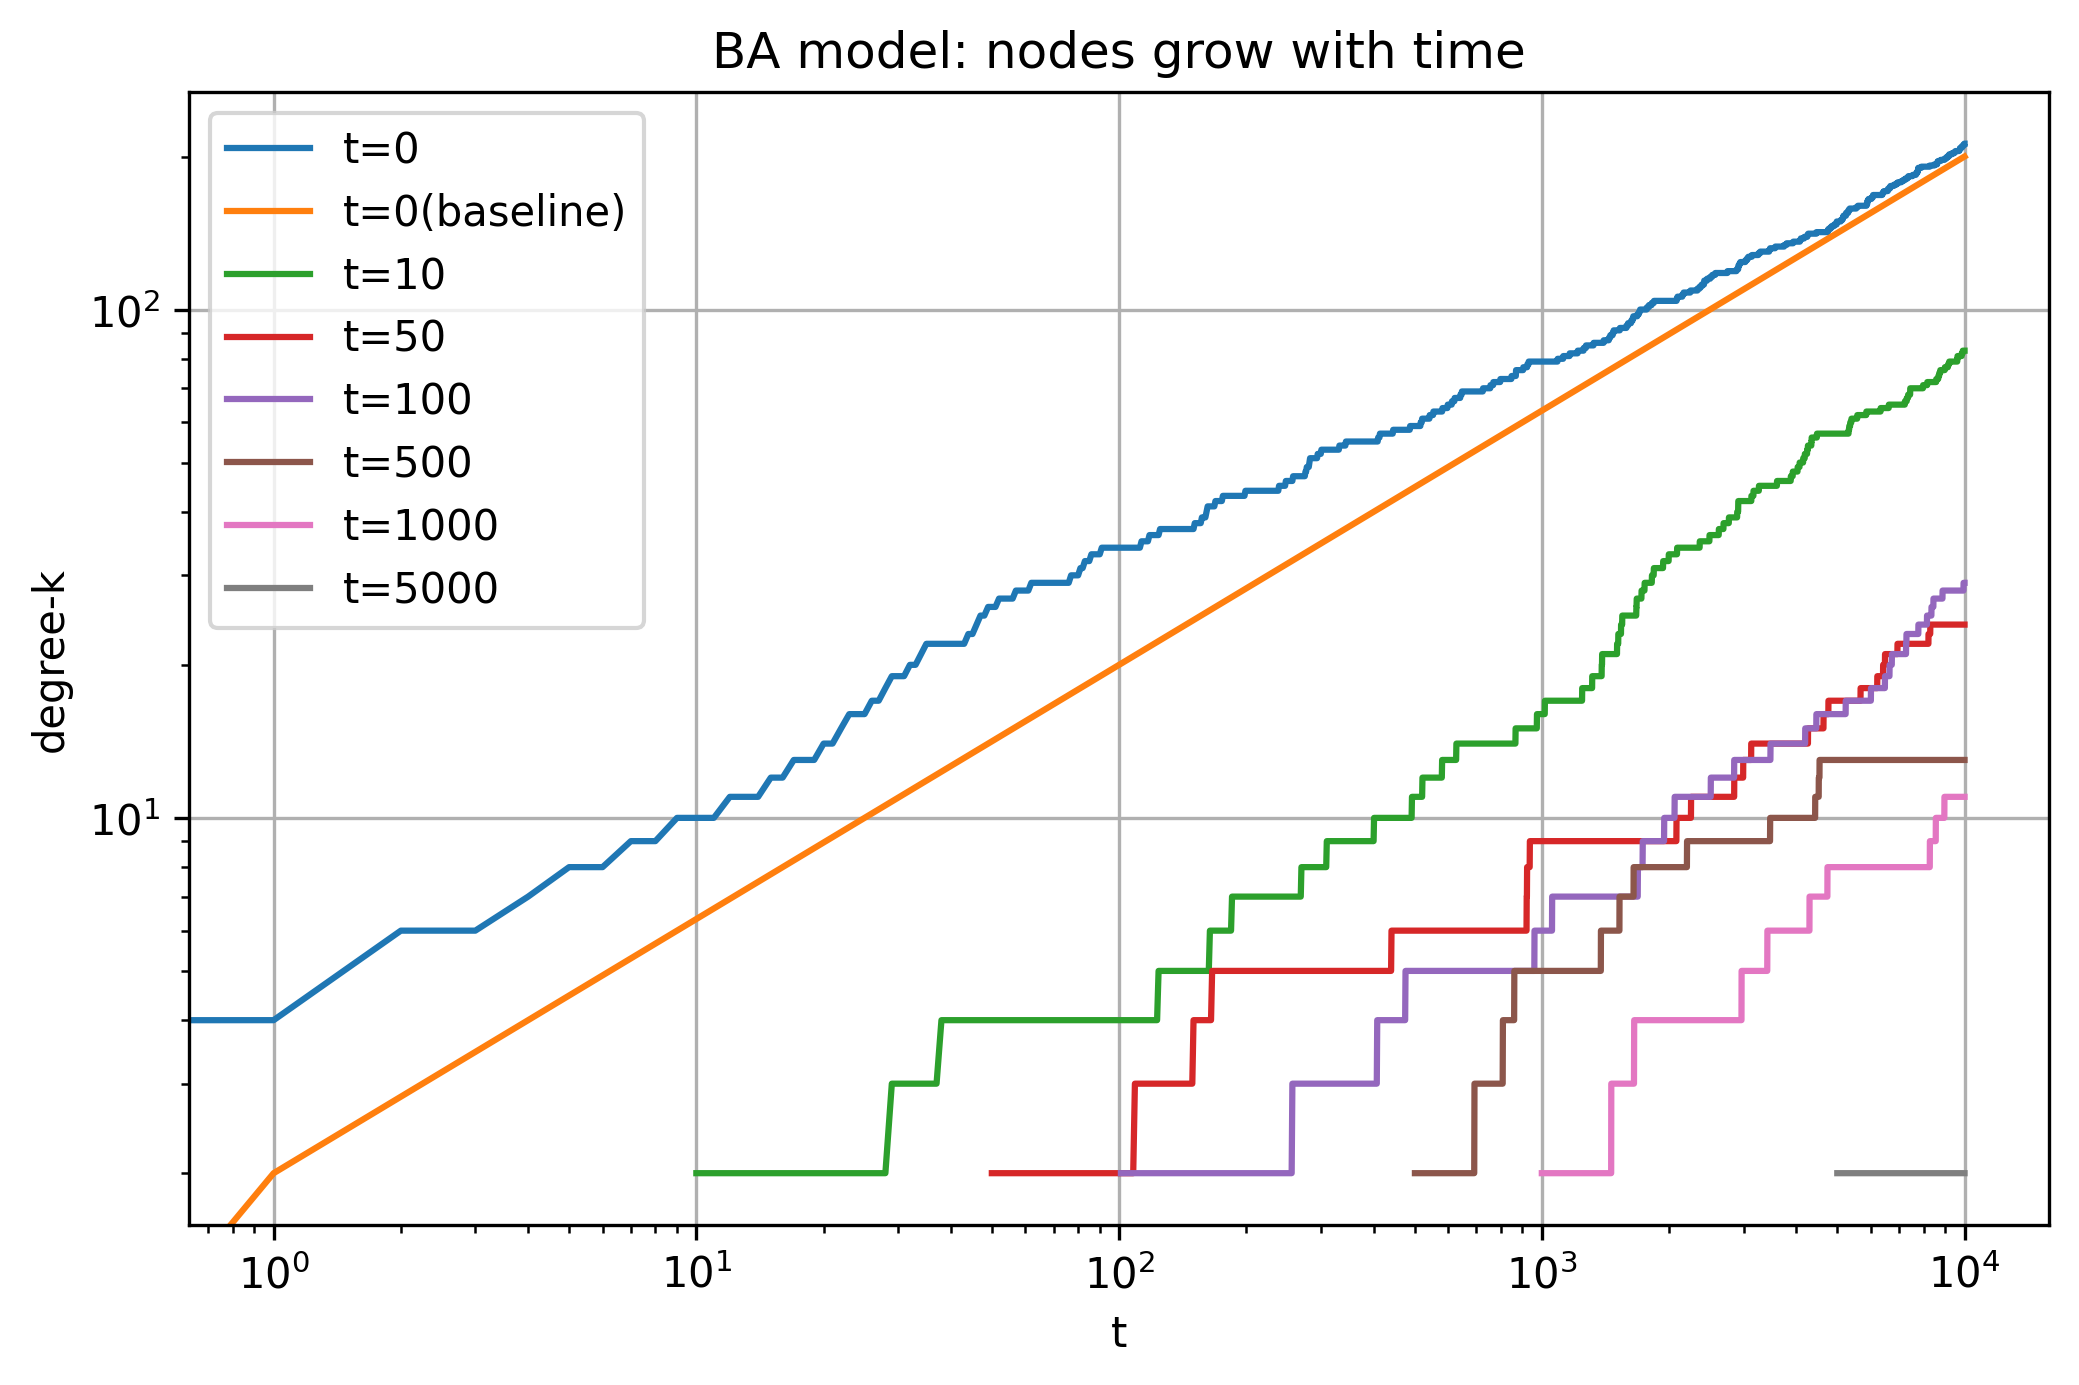

In [20]:
plt.figure(dpi=300,figsize=(8,5))
plt.title("BA model: nodes grow with time")
plt.xscale("log")
plt.yscale("log")
#添加画布内容 PAGE204:delta_k & delta_t
plt.xlabel('t',)  #通过提前预制的font字典，设置中文字体
plt.ylabel('degree-k')
x,y=degree_increase()
plt.plot(x,y)
#理论值page203，公式4.7，beita=1/2这个承睿也检查时否对
y=m*np.float_power(x,0.5)
plt.plot(x,y)

x,y=degree_increase(10)
plt.plot(x,y)
x,y=degree_increase(50)
plt.plot(x,y)
x,y=degree_increase(101)
plt.plot(x,y)
x,y=degree_increase(501)
plt.plot(x,y)
x,y=degree_increase(1000)
plt.plot(x,y)
x,y=degree_increase(5000)
plt.plot(x,y)
#增加图例
plt.legend(["t=0","t=0(baseline)","t=10",'t=50','t=100','t=500','t=1000','t=5000'])   ##增加图例
#plt.grid() #给， x,y轴同时添加网格线
plt.grid(axis='x') #在 x轴添加网格线
plt.grid(axis='y') #在 y轴添加网格线
#线性比较，证明BA网络的亚线性增长
# x=np.linspace(0,500,500)
# y=x
# plt.plot(x,y,linestyle='--')

基本正常？？

### 步骤2 网络中度分布的观察

p(k)与k的关系，已经通过步骤4，进行了描述，可以看出p(k)关于k的幂律分布。那如何量化这个幂律呢？引入了gama度指数分布
根据连续介质理论推导的数理统计方程：p(k)=2*m**(1/beita)*k**(-gama)

In [14]:
#连续介质理论的方程
def get_Pk(k,beita=0.5,gama=3):
    global m  #每个节点，加入时刻带来的边数量
    #np.float_power  np.float_power(5, -2)
    return 2*m**(1/beita)*np.float_power(k,-gama)
    #return 2*m**(1/beita)*k**(-gama)

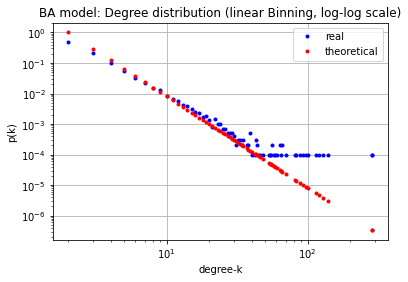

In [21]:
k_list=[]
pk_list=[]
c=Counter(nodes.d)
#按照值从小到大排序
cc=sorted(c.items(),key=lambda x:x[0]) 
#print(cc)
#线性标度图
for tmpk_nums in cc:
    k_list.append(tmpk_nums[0])
    pk_list.append(tmpk_nums[1]/len(nodes))
plt.title('BA model: Degree distribution (linear Binning, log-log scale)')

#添加画布内容
plt.xlabel('degree-k',)  #通过提前预制的font字典，设置中文字体
plt.ylabel('p(k)')
#双对数坐标-----线性分箱---观察值
plt.xscale("log")
plt.yscale("log")
plt.plot(k_list,pk_list,"b.")
#双对数坐标-----线性分箱---理论值
pk_list=get_Pk(k_list)
plt.plot(k_list,pk_list,"r.")
plt.legend(["real","theoretical"])   ##增加图例
#plt.grid() #给， x,y轴同时添加网格线
plt.grid(axis='x') #在 x轴添加网格线
plt.grid(axis='y') #在 y轴添加网格线

显然 p(k)和k的关系，不能在取对数后，验证gama=3，这样处理时的结果时糟糕的

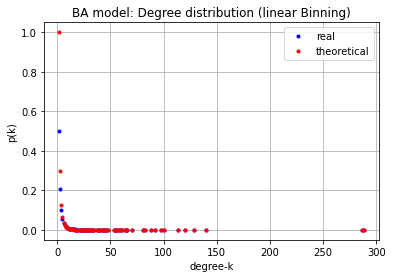

In [22]:
#普通坐标-----线性分箱---理论值
#线性标度图
k_list=[]
pk_list=[]
for tmpk_nums in cc:
    k_list.append(tmpk_nums[0])
    pk_list.append(tmpk_nums[1]/len(nodes))
#双对数坐标-----线性分箱---观察值
k_list=np.array(k_list)
plt.title('BA model: Degree distribution (linear Binning)')
#添加画布内容
plt.xlabel('degree-k',)  #通过提前预制的font字典，设置中文字体
plt.ylabel('p(k)')
plt.plot(k_list,pk_list,"b.")
#双对数坐标-----线性分箱---理论值
pk_list=get_Pk(k_list)
plt.plot(k_list,pk_list,"r.")
plt.legend(["real","theoretical"])   ##增加图例
#plt.grid() #给， x,y轴同时添加网格线
plt.grid(axis='x') #在 x轴添加网格线
plt.grid(axis='y') #在 y轴添加网格线

十分吻合，gama=3  beita=0.5  数据量只有1000个节点的情况下，吻合度相当好

利用拟合，求解幂指（以双对数的线性分箱为例）

## 实验3  此次模拟生长两个最重要的数据结构nodes和 edges

要观察动力学指标，务必按照下面两个数据结构采集数据

In [ ]:
#总度数
#数理统计: m*(2*t-1)=2*(2*499-1)   公式4.4 PAGE202
print(f"数理统计总度数{(2*totalT-1)*m}")
print(f"肉眼观察总度数{nodes.d.sum()}")

数理统计总度数3998
肉眼观察总度数3998


In [ ]:
nodes.head(5)

,t,label,d
0,t0,n0,49
1,t0,n1,65
2,t1,n2,75
3,t2,n3,12
4,t3,n4,25


In [ ]:
edges.head(5)

,t,n_start,n_end,weight,active
0,t0,n0,n1,0,1
1,t1,n0,n2,0,1
2,t1,n1,n2,0,1
3,t2,n0,n3,0,1
4,t2,n2,n3,0,1


## 实验4 networkx创建BA网络

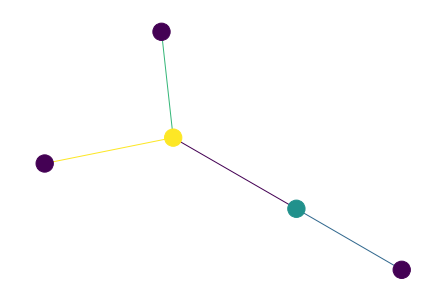

In [12]:
node_number=5
m_edges=1
#generate BA network
#生成一个含有n个节点、每次加入m条边的BA无标度网络
baG=nx.barabasi_albert_graph(node_number,m_edges) 
pos=nx.spring_layout(baG) #set layout
nodecolor=baG.degree() #度数越大，节点越大，连接边颜色越深
nodecolor2=pd.DataFrame(nodecolor) #转化称矩阵形式
nodecolor3=nodecolor2.iloc[:,1] #索引第二列
edgecolor=range(baG.number_of_edges()) #设置边权颜色
nx.draw(baG, pos, with_labels=False,
    #node_size=nodecolor3*6,  
    node_color=nodecolor3*5,
    edge_color=edgecolor,
    #node_cmap=plt.cm.Blues 
)
plt.savefig(f"BA网络-节点数{node_number}.jpg",dpi=1000)
#nx.draw() 函数绘图，G表示对象， pos表示布局        #with_labels设置标签，节点和边的大小和颜色

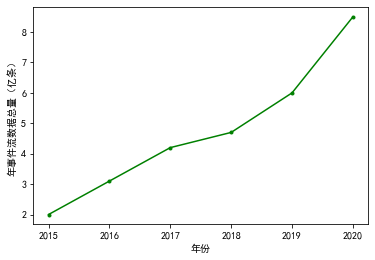

In [19]:
years = [2015,2016,2017,2018,2019,2020]
total_ops = [2.0,3.1,4.2,4.7,6,8.5]
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.title("2015-2020年间GitHub事件流数据量统计")
plt.xlabel("年份")
plt.ylabel("年事件流数据总量（亿条）")
plt.plot(years, total_ops,'g.-')